# How to split shapes with plotly

## The Task: Remove the westernmost islands from the Alaska shape so that it doesn't force a full-world map perspective

## Import Necessary Packages

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt

## Load US Shapefile

In [2]:
states_gdf = gpd.read_file('./data/cb_2018_us_state_5m.shp')

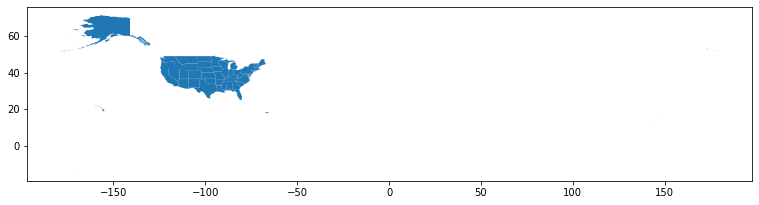

In [3]:
fig, ax = plt.subplots(figsize=(13,8))
states_gdf.plot(ax=ax)

In [4]:
states_gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


## Grab Alaska shape

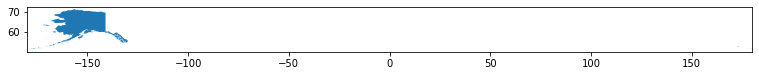

In [5]:
alaska_gdf = states_gdf.loc[states_gdf['STUSPS'] == "AK"]

# plot the alaska GeoDataFrame
fig, ax = plt.subplots(figsize=(13,8))
alaska_gdf.plot(ax=ax)
ax.set_xlim(-180, 180)

plt.savefig('./images/alaska_wide.png', bbox_inches='tight');

In [6]:
alaska_gdf['geometry']

55    MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...
Name: geometry, dtype: geometry

In [7]:
alaska_gdf['geometry'].values

<GeometryArray>
Length: 1, dtype: geometry

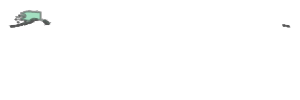

In [8]:
alaska_gdf['geometry'].values[0]

Now we've gotten to the Shapely MultiPolygon

In [9]:
alaska_mp = alaska_gdf['geometry'].values[0]

In [10]:
type(alaska_mp)

shapely.geometry.multipolygon.MultiPolygon

To get a single polygon:

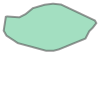

In [11]:
alaska_mp[0]

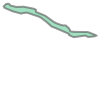

In [12]:
alaska_mp[1]

Number of polygons in Alaska's shape:

In [13]:
len(alaska_mp)

142

In [14]:
# convert these polygons into GeoDataFrame
ak_exp_gdf = gpd.GeoDataFrame(alaska_mp)

In [15]:
ak_exp_gdf

,0
0,"POLYGON ((179.482464 51.982834, 179.486565 51...."
1,"POLYGON ((178.625536 51.637303, 178.645511 51...."
2,"POLYGON ((178.446964 51.978222, 178.463385 51...."
3,"POLYGON ((178.236931 51.828209, 178.305568 51...."
4,"POLYGON ((178.09461 52.033294, 178.107266 52.0..."
...,...
137,"POLYGON ((-178.681285 51.608951, -178.638455 5..."
138,"POLYGON ((-178.857365 51.57659, -178.828811 51..."
139,"POLYGON ((-178.870118 51.795261, -178.858248 5..."
140,"POLYGON ((-178.992094 51.381311, -178.977782 5..."


In [16]:
# set geometry column
ak_exp_gdf.columns = ['geometry']

finding alaska polygons that are on the contiguous states' side of the international date line

In [17]:
from shapely.geometry import Polygon

# create polygon that covers area we do want
target_polygon = Polygon([(-180, 50), (-180, 75), (-100, 75), (-100, 50)])

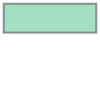

In [18]:
target_polygon

In [19]:
ak_exp_gdf.intersects(target_polygon)

0      False
1      False
2      False
3      False
4      False
       ...  
137     True
138     True
139     True
140     True
141     True
Length: 142, dtype: bool

In [20]:
eastern_ak = ak_exp_gdf.loc[ak_exp_gdf.intersects(target_polygon)].copy()

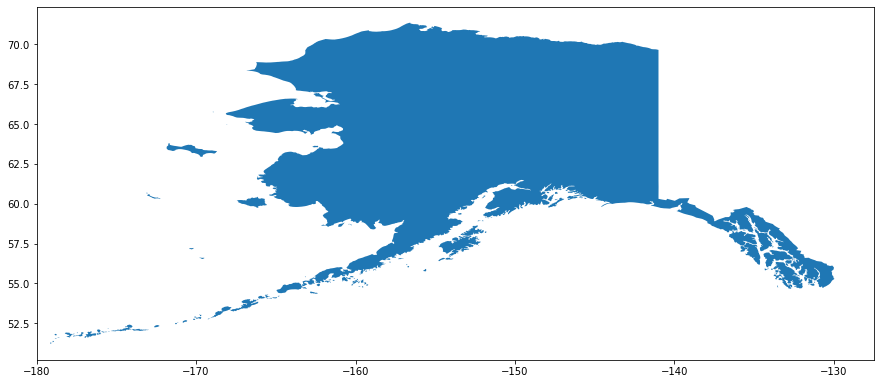

In [21]:
fig, ax = plt.subplots(figsize=(15, 12))
eastern_ak.plot(ax=ax)
ax.set_xlim(-180)
plt.savefig('./images/eastern_ak.png', bbox_inches='tight')

## Combining these shapes back into a single Alaska row

In [22]:
alaska_gdf

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
55,02,01785533,0400000US02,02,AK,Alaska,00,1478839695958,245481577452,"MULTIPOLYGON (((179.48246 51.98283, 179.48656 ..."


In [23]:
# add a column to groupby

eastern_ak['STUSPS'] = 'AK'
eastern_ak

,geometry,STUSPS
12,"POLYGON ((-131.24119 55.09255, -131.20728 55.1...",AK
13,"POLYGON ((-131.48662 54.95039, -131.48268 54.9...",AK
14,"POLYGON ((-131.62195 54.94653, -131.58487 54.9...",AK
15,"POLYGON ((-131.64628 55.03558, -131.62074 55.0...",AK
16,"POLYGON ((-131.87057 55.36455, -131.85430 55.4...",AK
...,...,...
137,"POLYGON ((-178.68129 51.60895, -178.63845 51.6...",AK
138,"POLYGON ((-178.85737 51.57659, -178.82881 51.5...",AK
139,"POLYGON ((-178.87012 51.79526, -178.85825 51.8...",AK
140,"POLYGON ((-178.99209 51.38131, -178.97778 51.3...",AK


In [24]:
alaska_trimmed = eastern_ak.dissolve(by='STUSPS')
alaska_trimmed

,geometry
STUSPS,
AK,"MULTIPOLYGON (((-179.13724 51.28601, -179.1135..."


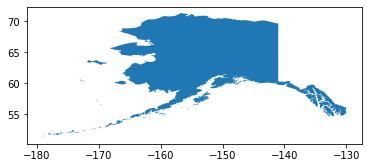

In [25]:
alaska_trimmed.plot()

In [26]:
states_trimmed = states_gdf.copy()
states_trimmed.loc[states_trimmed['STUSPS'] == 'AK', 'geometry'] = alaska_trimmed['geometry'].values

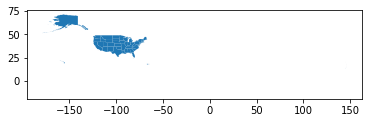

In [27]:
states_trimmed.plot()

## Trimming Alaska alone didn't solve my want to zoom in on the 50 States. I'll remove Guam, the Commonwealth of the Northern Mariana Islands, and American Samoa.

In [28]:
states_trimmed = states_trimmed.loc[states_trimmed['STUSPS'].isin(['GU', 'MP', 'AS']) == False]

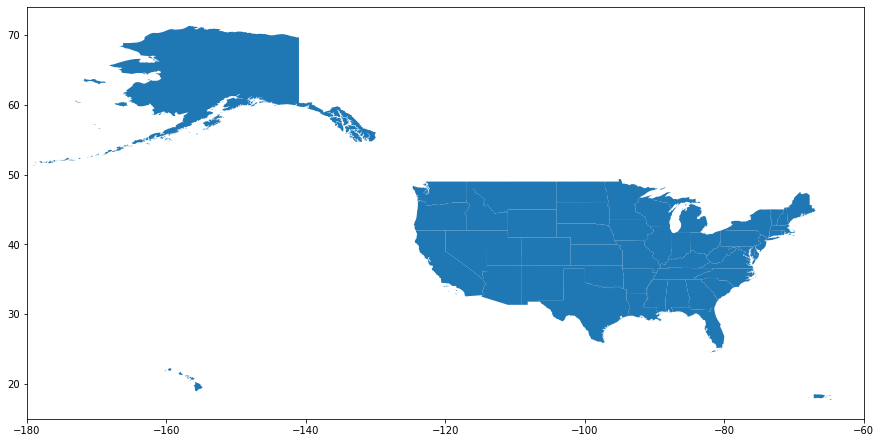

In [29]:
fig, ax = plt.subplots(figsize=(15, 9))
states_trimmed.plot(ax=ax)
ax.set_xlim(-180, -60)
plt.savefig('./images/us_trimmed.png', bbox_inches='tight')

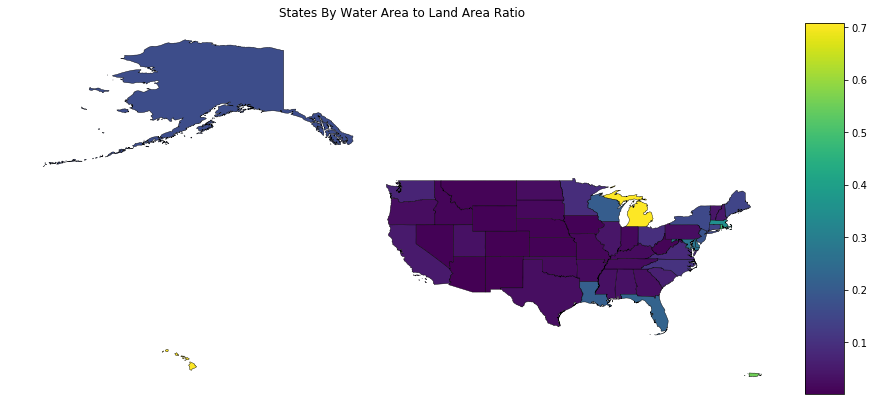

In [30]:
# with a choropleth

states_trimmed['water:land'] = states_trimmed['AWATER'] / states_trimmed['ALAND']
states_trimmed_v2 = states_trimmed.loc[states_trimmed['STUSPS'] != 'VI']

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(15,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
states_trimmed_v2.plot(column='water:land', ax=ax, legend=True, cax=cax, edgecolor="black", linewidth=.4)
ax.set_title('States By Water Area to Land Area Ratio')
ax.axis('off')

plt.savefig('images/states_water_land_area_choropleth.png', bbox_inches='tight')

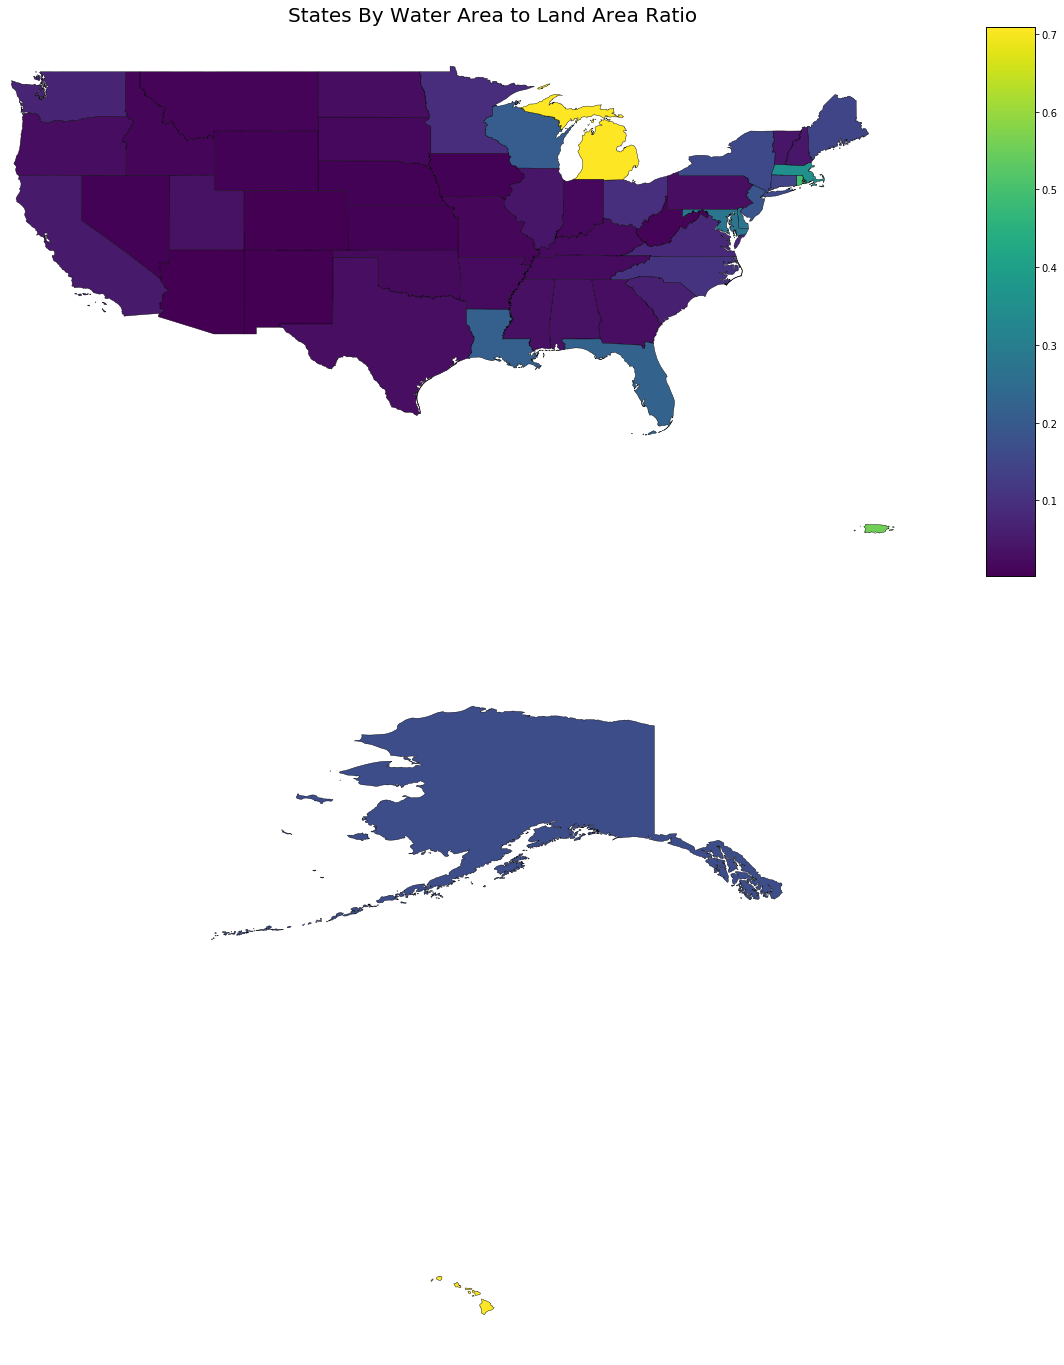

In [31]:
fig, axes = plt.subplots(nrows=2, figsize=(15,20))
plt.tight_layout()
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.1)
states_trimmed_v2.plot(column='water:land', ax=axes[0], legend=True, cax=cax, edgecolor="black", linewidth=.4)
axes[0].set_title('States By Water Area to Land Area Ratio', fontsize=20)
axes[0].axis('off')
axes[0].set_xlim(-125)
axes[0].set_ylim(15, 52)

states_trimmed_v2.plot(column='water:land', ax=axes[1], legend=True, cax=cax, edgecolor="black", linewidth=.4)
axes[1].axis('off')
axes[1].set_xlim(-180, -125)

plt.savefig('images/states_water_land_area_choropleth_big.png', bbox_inches='tight')

In [32]:
states_trimmed.sort_values(by='water:land', ascending=False)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,water:land
39,78,01802710,0400000US78,78,VI,United States Virgin Islands,00,348021896,1550236201,"MULTIPOLYGON (((-64.63432 17.79589, -64.62214 ...",4.454421
36,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-84.00966 46.10133, -83.98768 ...",0.708630
27,15,01779782,0400000US15,15,HI,Hawaii,00,16633990195,11777809026,"MULTIPOLYGON (((-156.05722 19.74254, -156.0523...",0.708057
51,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868896030,4922382562,"MULTIPOLYGON (((-65.33750 18.34834, -65.33570 ...",0.555016
30,44,01219835,0400000US44,44,RI,Rhode Island,00,2677779902,1323670487,"MULTIPOLYGON (((-71.36152 41.46483, -71.34707 ...",0.494316
37,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.27553 41.31046, -70.26063 ...",0.352877
42,24,01714934,0400000US24,24,MD,Maryland,00,25151100280,6979966958,"MULTIPOLYGON (((-76.04940 37.99031, -76.04881 ...",0.277521
29,10,01779781,0400000US10,10,DE,Delaware,00,5045925646,1399985648,"MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ...",0.277449
38,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.75164 24.85725, -80.72906 ...",0.225702
35,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.88145 30.05320, -88.87048 ...",0.212280


## Using intersection without breaking out individual polygons

In [38]:
from shapely.geometry import Polygon

desired_map = Polygon([(-180, 80), (-60, 80), (-60, 15), (-180, 15)])

states_trimmed_v3 = states_gdf.copy()
states_trimmed_v3['geometry'] = states_gdf.intersection(desired_map)

In [39]:
states_trimmed_v3.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,31,01779792,0400000US31,31,NE,Nebraska,00,198956658395,1371829134,"POLYGON ((-104.05351 41.15726, -104.05267 41.2..."
1,53,01779804,0400000US53,53,WA,Washington,00,172112588220,12559278850,"MULTIPOLYGON (((-122.32834 48.02134, -122.3217..."
2,35,00897535,0400000US35,35,NM,New Mexico,00,314196306401,728776523,"POLYGON ((-109.05017 31.48000, -109.04984 31.4..."
3,46,01785534,0400000US46,46,SD,South Dakota,00,196346981786,3382720225,"POLYGON ((-104.05770 44.99743, -104.05021 44.9..."
4,48,01779801,0400000US48,48,TX,Texas,00,676653171537,19006305260,"POLYGON ((-106.64548 31.89867, -106.64084 31.9..."


TypeError: 'Polygon' object is not subscriptable

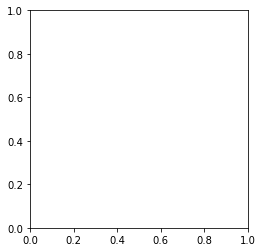

In [41]:
states_trimmed_v3.plot()

In [45]:
states_trimmed_v3['geometry']

0     POLYGON ((-104.05351 41.15726, -104.05267 41.2...
1     MULTIPOLYGON (((-122.32834 48.02134, -122.3217...
2     POLYGON ((-109.05017 31.48000, -109.04984 31.4...
3     POLYGON ((-104.05770 44.99743, -104.05021 44.9...
4     POLYGON ((-106.64548 31.89867, -106.64084 31.9...
5     MULTIPOLYGON (((-118.60337 33.47810, -118.5987...
6     MULTIPOLYGON (((-89.40565 36.52817, -89.39869 ...
7     MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ...
8     MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...
9     POLYGON ((-85.60516 34.98468, -85.55259 34.984...
10    MULTIPOLYGON (((-86.95620 45.35201, -86.95339 ...
11    POLYGON ((-124.55244 42.84057, -124.50014 42.9...
12    POLYGON ((-80.51989 40.90666, -80.51909 40.921...
13    MULTIPOLYGON (((-88.51067 30.21702, -88.49238 ...
14    POLYGON ((-95.77355 40.57820, -95.76853 40.583...
15    MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...
16    POLYGON ((-103.00257 36.52659, -103.00219 36.6...
17    POLYGON ((-82.64300 38.16956, -82.63905 38

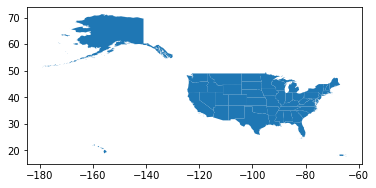

In [47]:
states_trimmed_v3[states_trimmed_v3['geometry'] != Polygon()].plot()

## Let's try another way to adjust Alaska without cutting off the western islands

In [115]:
# first I thought to shift with .translate(). Unfortunately this didn't
# compensate for the circular globe. 
# latitute 170 became 200 instead of -120

alaska_shifted = alaska_gdf.translate(xoff=30)

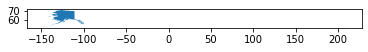

In [116]:
alaska_shifted.plot()

In [49]:
western_isles = ak_exp_gdf.loc[ak_exp_gdf.intersects(target_polygon) == False]

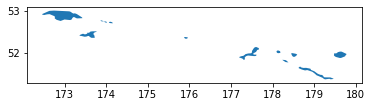

In [50]:
western_isles.plot()

In [51]:
western_isles_shifted = western_isles.translate(xoff=-360)

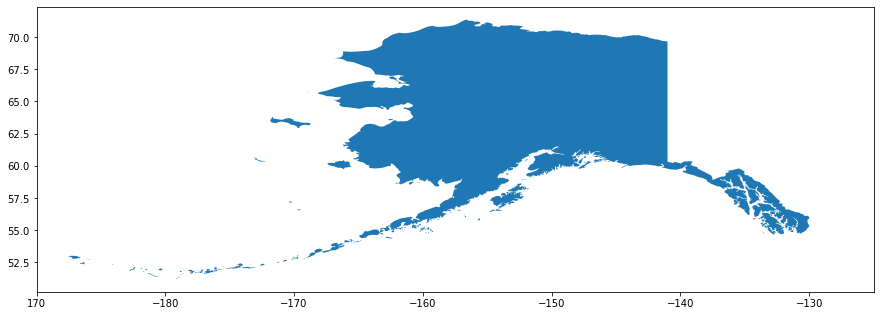

In [52]:
fig, ax = plt.subplots(figsize=(15, 12))
western_isles_shifted.plot(ax=ax)
alaska_trimmed.plot(ax=ax)

locs, labels = plt.xticks()
labels[1] = '170'
plt.xticks(locs, labels)
plt.xlim(-190, -125)

plt.savefig('./images/alaska170_neg125', bbox_inches='tight')

### Use append to combine alaska shapes into a single dataframe for "dissolving"

In [270]:
west_ak_shift_gdf = gpd.GeoDataFrame(western_isles_shifted)
west_ak_shift_gdf.columns = ['geometry']
west_ak_shift_gdf['STUSPS'] = 'AK'

ak_shifted_actual_gdf = west_ak_shift_gdf.append(eastern_ak, ignore_index=True)

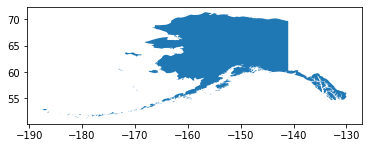

In [271]:
ak_shifted_actual_gdf.plot()

In [159]:
ak_shifted_actual_dissolved = ak_shifted_actual_gdf.dissolve(by='STUSPS')

In [161]:
states_shifted = states_gdf.copy()
states_shifted.loc[states_shifted['STUSPS'] == 'AK', 'geometry'] = ak_shifted_actual_dissolved['geometry'].values

In [167]:
# removing the pacific island territories
states_shifted_trimmed = states_shifted.loc[states_shifted['STUSPS'].isin(['GU', 'MP', 'AS']) == False]

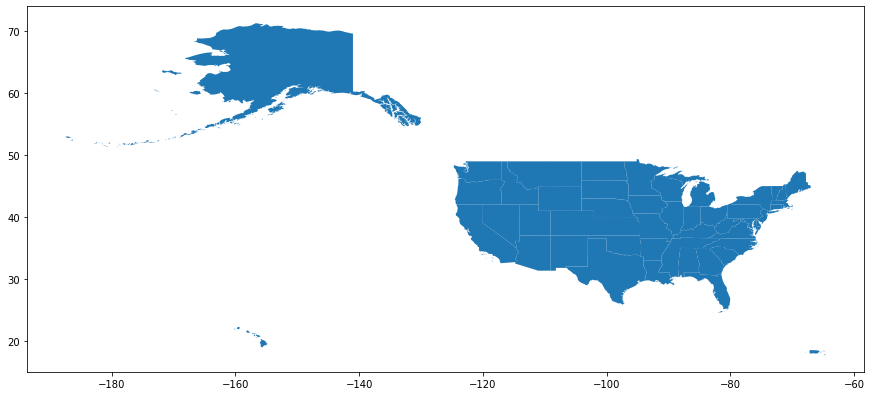

In [227]:
fig, ax = plt.subplots(figsize=(15,15))
states_shifted_trimmed.plot(ax=ax)
plt.show();

## Test out CartoPy for a different projection

install with: conda install -c conda-forge cartopy

See full [installation guide](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing).

In [54]:
import cartopy.crs as ccrs

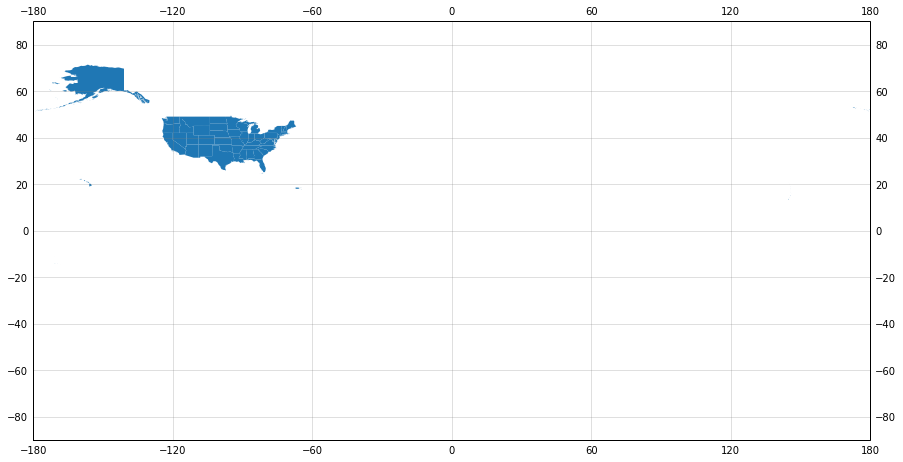

In [55]:
fig = plt.figure(figsize=(15, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries(states_gdf['geometry'], 
                  crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='gray', alpha=0.5)
plt.savefig('./images/cartopy_plate_carree.png', bbox_inches='tight');

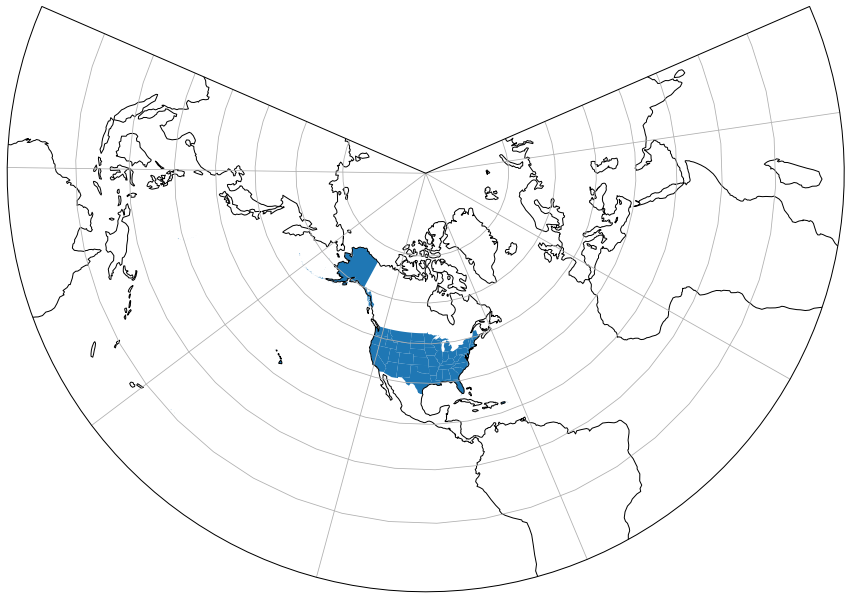

In [62]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection = ccrs.LambertConformal())
ax.add_geometries(states_gdf['geometry'], crs = ccrs.PlateCarree())
ax.coastlines()
ax.gridlines();

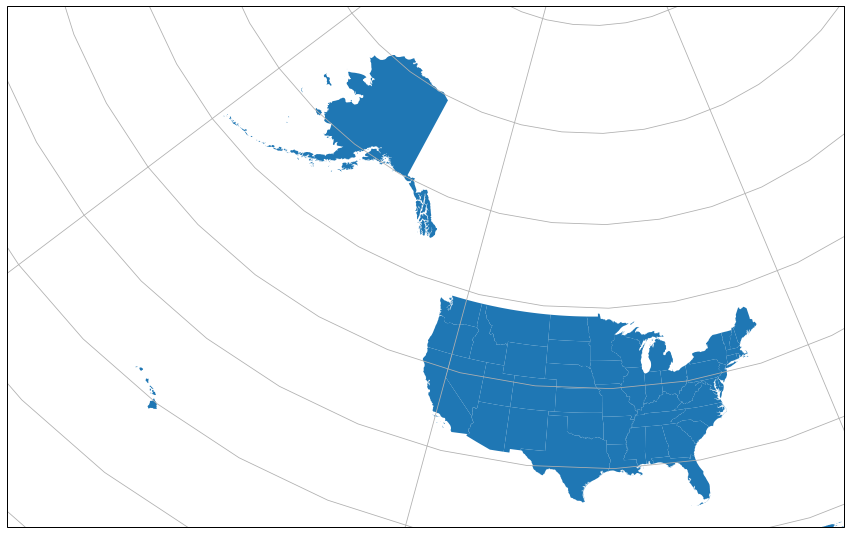

In [60]:
fig = plt.figure(figsize=(15,15))
bounds= states_trimmed.total_bounds
ax = plt.axes(projection = ccrs.LambertConformal())
ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])
ax.add_geometries(states_trimmed.geometry, crs=ccrs.PlateCarree())
ax.gridlines();

In [72]:
bounds

array([-179.14734 ,   17.674091,  -64.566547,   71.352561])

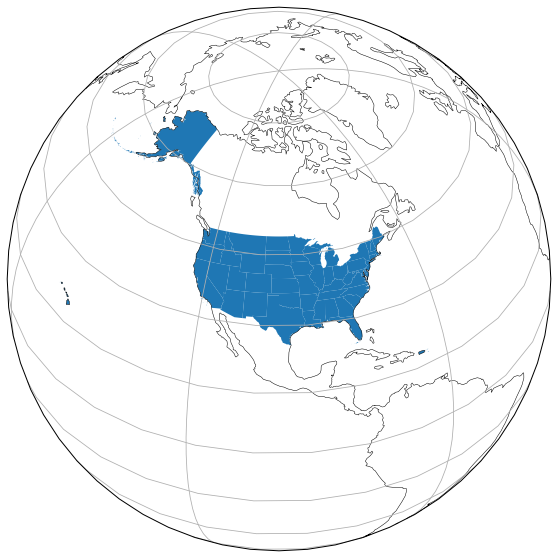

In [74]:
fig = plt.figure(figsize=(10,10))

# set desired projection/view
ax = plt.axes(projection = ccrs.Orthographic(central_longitude=-100, 
                                             central_latitude=40))
# add your shapes (indicating their existing projection)
ax.add_geometries(states_gdf.geometry, crs=ccrs.PlateCarree())

# add coastlines and gridlines for context
ax.coastlines(linewidth=.5)
ax.gridlines()

plt.savefig('./images/orthographic_proj.png', bbox_inches='tight')

With a Choropleth:

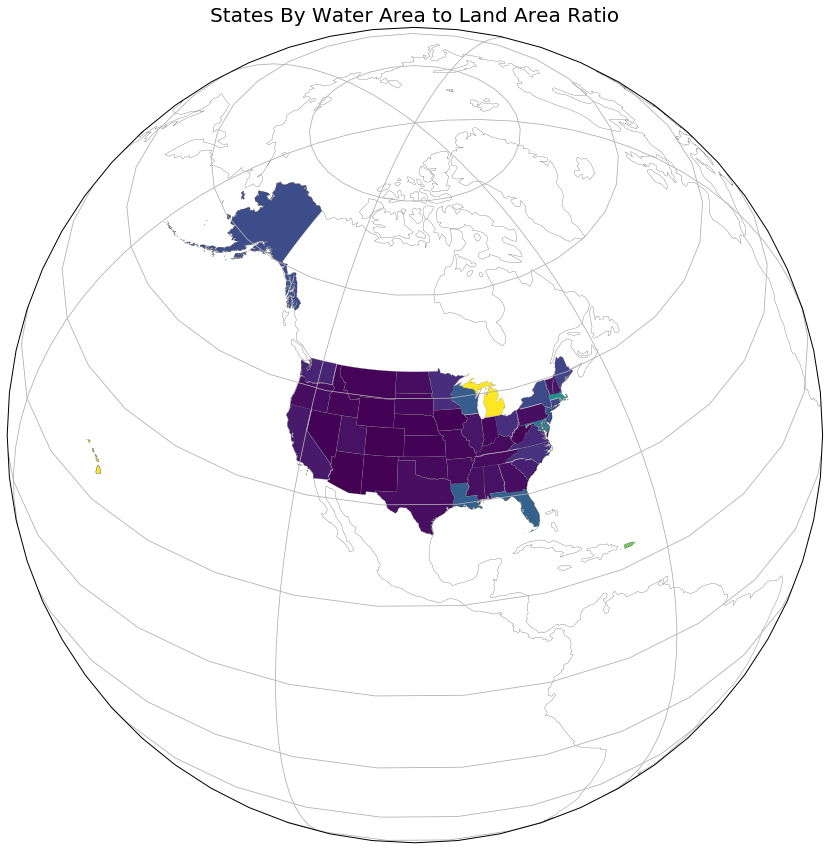

In [93]:
from matplotlib.colors import Normalize

# value normalization for the color map
values = list(states_trimmed_v2['water:land'])
norm = Normalize(vmin=min(values), vmax=max(values))

# select color map
cmap = plt.cm.get_cmap('viridis')

#create chorpleth: set fig and ax projection
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection = ccrs.Orthographic(central_longitude=-100, central_latitude=40))

# add each state to the ax with its appropriate facecolor
for state_i in states_trimmed_v2.index:
    geom = []
    geom.append(states_trimmed_v2.loc[state_i, 'geometry'])
    facecolor = cmap(norm(states_trimmed_v2.loc[state_i, 'water:land']))
    ax.add_geometries(geom, 
                      ccrs.PlateCarree(), 
                      facecolor=facecolor, 
                      edgecolor='grey', 
                      linewidth=.2)
    
ax.set_title('States By Water Area to Land Area Ratio', fontsize=20)
ax.coastlines(linewidth=.2)
ax.gridlines()

plt.savefig('./images/orthographic_choropleth.png', bbox_inches='tight')

## Alternative: Set the XLim in pyplot

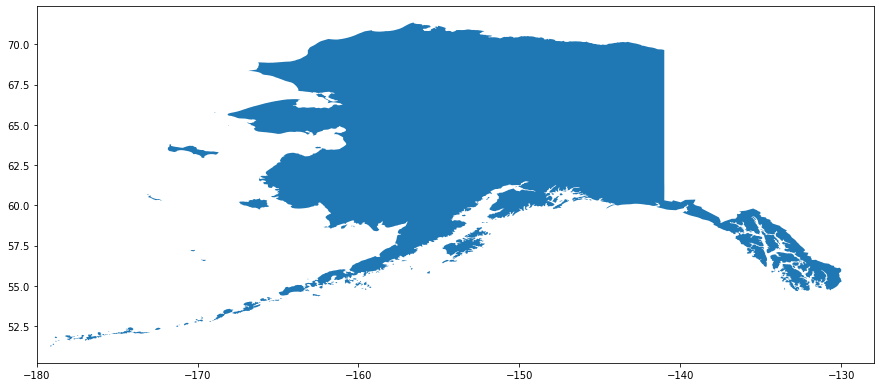

In [48]:
fig, ax = plt.subplots(figsize=(15,10))
alaska_gdf.plot(ax=ax)
ax.set_xlim(-180, -128)

plt.savefig("./images/alaska_xlim", bbox_inches='tight');